In [14]:
import torch
from torch import nn
import os
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, t):
        N, C, _, _ = x.shape
        t = self.mlp(t)
        t = t.view(N, C, 1, 1)
        y = self.convs(x + t)
        return y

In [16]:
def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)  # ①i = [0, 1, ..., D-1]
    div_term = 10000 ** (i / D)

    # ②偶数の位置にsin、奇数の位置にcos
    v[0::2] = torch.sin(t / div_term[::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

In [17]:
def pos_encoding(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

In [18]:
class UNet(nn.Module):
    def __init__(self, out_ch=3, time_dim=100):
        super().__init__()
        self.time_dim = time_dim

        self.down1 = ConvBlock(3, 64, time_dim)
        self.down2 = ConvBlock(64, 128, time_dim)
        self.bot1 = ConvBlock(128, 256, time_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_dim)
        self.out = nn.Conv2d(64, out_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, t):
        v = pos_encoding(t, self.time_dim, x.device)  # 正弦波位置エンコーディング

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x

In [19]:
file_path = 'buiiki.png'
image = plt.imread(file_path)
print(image.shape)  # (64, 64, 3)

# 画像の前処理を定義
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)  # (3, 64, 64)

(64, 64, 3)
torch.Size([3, 64, 64])


In [20]:
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

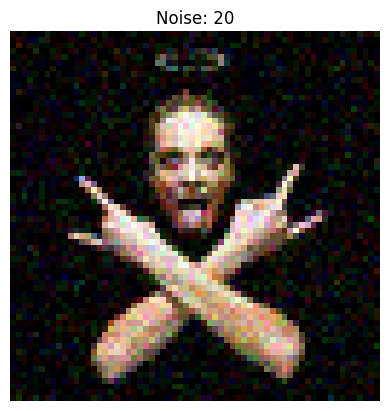

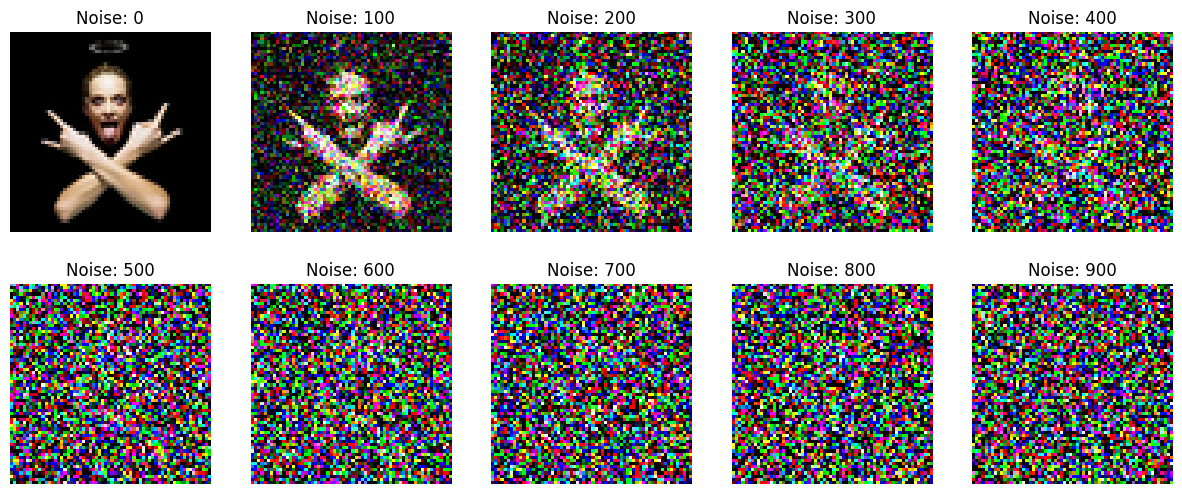

In [21]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

def add_noise(x_0, t, betas):
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alpha_bar = alpha_bars[t]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t

# 時刻100のノイズ画像を生成
t = 20
x_t = add_noise(x, t, betas)

# 画像の表示
img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)

    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# 10個の画像を2行5列で表示する
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()

In [22]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cuda"):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        # ① ======================================
        t = t.to(device)  # Add this line
        alpha_bar = self.alpha_bars[t]  # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # (N, 1, 1, 1)
        # ========================================
        noise = torch.randn_like(x_0, device=self.device)

        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise
    def denoise(self, model, x, t):
        alpha = self.alphas[t]
        alpha_bar = self.alpha_bars[t]
        alpha_bar_prev = self.alpha_bars[t-1]

        # ブロードキャストが正しく行われるための設定
        alpha = alpha.view(-1, 1, 1, 1)
        alpha_bar = alpha_bar.view(-1, 1 ,1, 1)
        alpha_bar_prev = alpha_bar_prev.view(-1, 1, 1, 1)
        # ニューラルネットワークの実行
        model.eval()  # 評価モードにする
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)

        if t[0] == 0:
            return mu
        else:
            noise = torch.randn_like(x, device=self.device)
            variance = (1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar)

            return mu + noise * torch.sqrt(variance)
    def reverse_to_img(self, x):
        x = x * 255.
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        # self.num_timestepsの値から1ずつ減らしていく逆順のループ
        for i in tqdm(range(self.num_timesteps)[::-1]):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            
            x = self.denoise(model, x, t)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images

In [23]:
img_size = 28
batch_size = 128
timesteps = 1000
epochs = 10
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"


def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap="gray")
            plt.axis('off')  # 縦軸、横軸を非表示にする
            i += 1
    plt.show()

In [24]:
class CatCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        cat_idx = self.classes.index('cat')
        self.data = self.data[np.array(self.targets) == cat_idx]
        self.targets = [cat_idx]*len(self.data)

In [25]:
preprocess = transforms.ToTensor()
dataset = CatCIFAR10(root="./data", download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(timesteps)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

Files already downloaded and verified


In [26]:
random_indices = random.sample(range(len(dataset)), 5)
random_images = [dataset[i] for i in random_indices]

# 画像を表示する
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (image, _) in enumerate(random_images):
    image = image.numpy().transpose((1, 2, 0))  # チャネル次元を最後に移動
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()


NameError: name 'random' is not defined

In [ ]:
losses = []
for epoch in range(epochs):
    loss_sum = 0
    cnt = 0
    #エポックごとにデータ生成して結果を確認したい場合は下記のコメントアウトをとる
    #images = diffuser.sample(model)
    #show_images(images)
    for batch in tqdm(dataloader):
        cnt = cnt+ 1
        optimizer.zero_grad()
        x = batch[0].to(device)
        t = torch.randint(0, timesteps, (len(x),), device=device).long()
        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    #print(f"Epoch {epoch} | Loss: {loss_avg}")

# 損失のグラフ
plt.plot(losses)

# 画像を生成
images = diffuser.sample(model)
show_images(images)

: 